# Encoding A Large Knowledge Graph Part 2

In this notebook, we will continue where we left off by building a new multi-hop QA dataset based on Wikidata.

## Example 2: Building a new Dataset from Questions and an already-existing Knowledge Graph

### Motivation

One potential application of knowledge graph structural encodings is capturing the relationships between different entities that are multiple hops apart. This can be challenging for an LLM to recognize from prepended graph information. Here's a motivating example (credit to @Rishi Puri):

In [1]:
from IPython.display import SVG

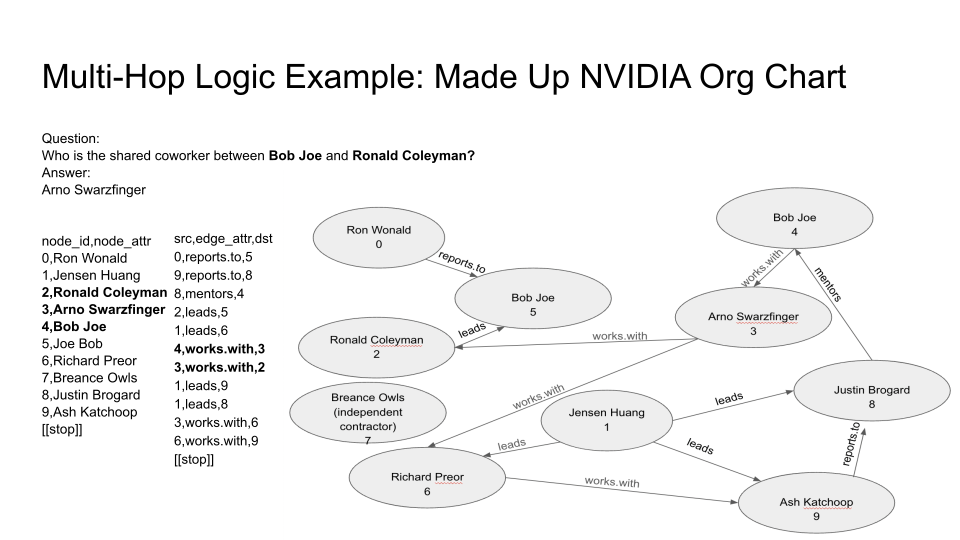

In [2]:
SVG(filename='./media/multihop_example.svg')

In this example, the question can only be answered by reasoning about the relationships between the entities in the knowledge graph.

### Building a Multi-Hop QA Dataset

To start, we need to download the raw data of a knowledge graph. In this case, we use WikiData5M ([Wang et al](https://paperswithcode.com/paper/kepler-a-unified-model-for-knowledge)). Here we download the raw triplets and their entity codes. Information about this dataset can be found [here](https://deepgraphlearning.github.io/project/wikidata5m).

The following download contains the ID to plaintext mapping for all the entities and relations in the knowledge graph:

In [ ]:
!wget -O "https://www.dropbox.com/s/lnbhc8yuhit4wm5/wikidata5m_alias.tar.gz"

In [ ]:
!tar -xvf "wikidata5m_alias.tar.gz"

In [ ]:
with open('wikidata5m_entity.txt') as f:
    print(f.readline())

In [ ]:
with open('wikidata5m_relation.txt') as f:
    print(f.readline())

And then this download contains the raw triplets:

In [ ]:
!wget -O "https://www.dropbox.com/s/563omb11cxaqr83/wikidata5m_all_triplet.txt.gz"

In [ ]:
!gzip -d "wikidata5m_all_triplet.txt.gz" -f

In [ ]:
with open('wikidata5m_all_triplet.txt') as f:
    print(f.readline())

To start, we are going to preprocess the knowledge graph to substitute each of the entity/relation codes with their plaintext aliases. This makes it easier to use a pre-trained textual encoding model to create triplet embeddings, as such a model likely won't understand how to properly embed the entity codes.

In [ ]:
import pandas as pd
import tqdm
import json

In [ ]:
# Substitute entity codes with their aliases
# Picking the first alias for each entity (rather arbitrarily)
alias_map = {}
rel_alias_map = {}
for line in open('wikidata5m_entity.txt'):
    parts = line.strip().split('\t')
    entity_id = parts[0]
    aliases = parts[1:]
    alias_map[entity_id] = aliases[0]
for line in open('wikidata5m_relation.txt'):
    parts = line.strip().split('\t')
    relation_id = parts[0]
    relation_name = parts[1]
    rel_alias_map[relation_id] = relation_name

In [ ]:
full_graph = []
missing_total = 0
total = 0
for line in tqdm.tqdm(open('wikidata5m_all_triplet.txt')):
    src, rel, dst = line.strip().split('\t')
    if src not in alias_map:
        missing_total += 1
    if dst not in alias_map:
        missing_total += 1
    if rel not in rel_alias_map:
        missing_total += 1
    total += 3
    full_graph.append([alias_map.get(src, src), rel_alias_map.get(rel, rel), alias_map.get(dst, dst)])
print(f"Missing aliases: {missing_total}/{total}")

In [ ]:
full_graph[:10]

Now `full_graph` represents the knowledge graph triplets in understandable plaintext.

Next, we need a set of multi-hop questions that the Knowledge Graph will provide us with context for. We utilize a subset of [HotPotQA](https://hotpotqa.github.io/) ([Yang et. al.](https://arxiv.org/pdf/1809.09600)) called [2WikiMultiHopQA](https://github.com/Alab-NII/2wikimultihop) ([Ho et. al.](https://aclanthology.org/2020.coling-main.580.pdf)), which includes a subgraph of entities that serve as the ground truth justification for answering each multi-hop question:

In [ ]:
!wget -O "https://www.dropbox.com/s/ms2m13252h6xubs/data_ids_april7.zip"

In [ ]:
!unzip -o "data_ids_april7.zip"

In [ ]:
with open('train.json') as f:
    train_data = json.load(f)
train_df = pd.DataFrame(train_data)
train_df['split_type'] = 'train'

with open('dev.json') as f:
    dev_data = json.load(f)
dev_df = pd.DataFrame(dev_data)
dev_df['split_type'] = 'dev'

with open('test.json') as f:
    test_data = json.load(f)
test_df = pd.DataFrame(test_data)
test_df['split_type'] = 'test'

df = pd.concat([train_df, dev_df, test_df])

In [ ]:
df.head()

In [ ]:
df['split_type'].value_counts()

In [ ]:
df['type'].value_counts()

Now we need to extract the subgraphs

In [ ]:
df['graph_size'] = df['evidences_id'].apply(lambda row: len(row))

In [ ]:
df['graph_size'].value_counts()

(Optional) We take only questions where the evidence graph is greater than 0. (Note: this gets rid of the test set):

In [ ]:
# df = df[df['graph_size'] > 0]

In [ ]:
df['split_type'].value_counts()

In [ ]:
df.columns

In [ ]:
refined_df = df[['_id', 'question', 'answer', 'split_type', 'evidences_id', 'type', 'graph_size']]

In [ ]:
refined_df.head()

Checkpoint:

In [ ]:
refined_df.to_csv('wikimultihopqa_refined.csv', index=False)

Now we need to check that all the entities mentioned in the question/answer set are also present in the Wikidata graph:

In [ ]:
relation_map = {}
with open('wikidata5m_relation.txt') as f:
    for line in tqdm.tqdm(f):
        parts = line.strip().split('\t')
        for i in range(1, len(parts)):
            if parts[i] not in relation_map:
                relation_map[parts[i]] = []
            relation_map[parts[i]].append(parts[0])

In [ ]:
# Manually check to see if all of these are valid in WikiData DB, even if they may not be answerable in WikiData5M
for row in refined_df.itertuples():
    for trip in row.evidences_id:
        relation = trip[1]
        if relation not in relation_map:
            print(f'The following relation is not found: {relation}')
        elif len(relation_map[relation]) > 1:
            print(f'The following relation alias has a collision: {relation}: {relation_map[relation]}')

In [ ]:
entity_set = set()
with open('wikidata5m_entity.txt') as f:
    for line in tqdm.tqdm(f):
        entity_set.add(line.strip().split('\t')[0])

In [ ]:
missing_entities = set()
missing_entity_idx = set()
for i, row in enumerate(refined_df.itertuples()):
    for trip in row.evidences_id:
        if len(trip) != 3:
            print(trip)
        entities = trip[0], trip[2]
        for entity in entities:
            if entity not in entity_set:
                print(f'The following entity was not found in the KG: {entity}')
                missing_entities.add(entity)
                missing_entity_idx.add(i)

Right now, we drop the missing entity entries. Additional preprocessing can be done here to resolve the entity/relation collisions, but that is out of the scope for this notebook.

In [ ]:
len(missing_entity_idx)

In [ ]:
refined_df.shape

In [ ]:
# missing relations are ok, but missing entities cannot be mapped to plaintext, so they should be dropped.
refined_df.reset_index(inplace=True, drop=True)
refined_df

In [ ]:
cleaned_df = refined_df.drop(missing_entity_idx)
cleaned_df['split_type'].value_counts()

Now we save the resulting graph and questions/answers dataset:

In [ ]:
cleaned_df.to_csv('wikimultihopqa_cleaned.csv', index=False)

In [ ]:
import torch

In [ ]:
torch.save(full_graph, 'wikimultihopqa_full_graph.pt')

### Question: How do we extract a contextual subgraph for a given query?

The chosen retrieval algorithm is a critical component in the pipeline for affecting RAG performance. In the next section (1), we will demonstrate a naive method of retrieval for a large knowledge graph, and how to apply it to this dataset along with WebQSP.

### Preparing a Textualized Graph for LLM

For now however, we need to prepare the graph data to be used as a plaintext prefix to the LLM. In order to do this, we want to prompt the LLM to use the unique nodes, and unique edge triplets of a given subgraph. In order to do this, we prepare a unique indexed node df and edge df for the knowledge graph now. This process occurs trivially with the LargeGraphIndexer:

In [ ]:
from torch_geometric.data import LargeGraphIndexer

In [ ]:
indexer = LargeGraphIndexer.from_triplets(full_graph)

In [ ]:
# Node DF
textual_nodes = pd.DataFrame.from_dict(
    {"node_attr": indexer.get_node_features()})
textual_nodes["node_id"] = textual_nodes.index
textual_nodes = textual_nodes[["node_id", "node_attr"]]

In [ ]:
textual_nodes.head()

Notice how LargeGraphIndexer ensures that there are no duplicate indices:

In [ ]:
textual_nodes['node_attr'].unique().shape[0]/textual_nodes.shape[0]

In [ ]:
# Edge DF
textual_edges = pd.DataFrame(indexer.get_edge_features(),
                                columns=["src", "edge_attr", "dst"])
textual_edges["src"] = [
    indexer._nodes[h] for h in textual_edges["src"]
]
textual_edges["dst"] = [
    indexer._nodes[h] for h in textual_edges["dst"]
]

Note: The edge table refers to each node by its index in the node table. We will see how this gets utilized later when indexing a subgraph.

In [ ]:
textual_edges.head()

Now we can save the result

In [ ]:
textual_nodes.to_csv('wikimultihopqa_textual_nodes.csv', index=False)
textual_edges.to_csv('wikimultihopqa_textual_edges.csv', index=False)

Now were done! This knowledge graph and dataset will get used later on in Section 1.

In [ ]:
# TODO: Refactor everything below this point into its own notebook

# Generating Subgraphs

In [ ]:
from profiling_utils import create_remote_backend_from_triplets
from rag_feature_store import SentenceTransformerFeatureStore
from rag_graph_store import NeighborSamplingRAGGraphStore
from torch_geometric.loader import RAGQueryLoader
from torch_geometric.nn.nlp import SentenceTransformer
from torch_geometric.datasets.updated_web_qsp_dataset import preprocess_triplet, retrieval_via_pcst
from torch_geometric.data import get_features_for_triplets_groups, Data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentenceTransformer(model_name='sentence-transformers/all-roberta-large-v1').to(device)

In [ ]:
fs, gs = create_remote_backend_from_triplets(full_graph, model, model, NeighborSamplingRAGGraphStore, SentenceTransformerFeatureStore, 'encode', 'encode', preprocess_triplet, 'wikidata_graph', node_method_kwargs={"batch_size": 256}).load()

In [ ]:
import torch
import pandas as pd

In [ ]:
graphs = torch.load('subg_results.pt')
graph_df = pd.read_csv("wikimultihopqa_cleaned.csv")

In [ ]:
graph_df['is_train'].value_counts()

In [ ]:
graph_df.head()

In [ ]:
graph_df['is_train'].value_counts()